#### Imports

In [1]:
from helpers import graphSelector,remove_subs
import networkx as nx
from copy import deepcopy
import matplotlib.pyplot as plt
import subprocess
from subprocess import call
import threading
import base64
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
from random import choices
from collections import defaultdict



#### Functions

In [20]:

def get_all_components(articulation_nodes,G):
    """
    creates a dictionary mapping articulation points to the components resulting from its removal (excluding mainnet)
    """
    all_components = {}
    for node in articulation_nodes:
        components = temp_remove(G, node)
        mainnet = max(components,key=len)
        components.remove(mainnet)
        nodes_in_components = sum([len(x) for x in components])
        nbr_of_components = len(components)

        # print(G.degree[node],nbr_of_components,nodes_in_components)
        if nodes_in_components/nbr_of_components > 1:
            print(node,nodes_in_components/nbr_of_components)
        all_components[node] = components
    return all_components

def temp_remove(G,v_id):
    """
    create a copy of the graph, remove the node (art. point), and return the resulting components
    """
    temp_G = deepcopy(G)
    temp_G.remove_nodes_from([v_id])
    components = list(nx.connected_components(temp_G)) # AT LEAST 2
    return  components


def generate_paths(G,nodes):
    """
    pick 2 random points, find the shortest path between them (hops) 
    make a list of shortest paths and keep a count of the occurences of nodes in each path (dict: node->int)
    """
    node_count = defaultdict(int)
    for i in range(int(len(nodes)*10)): # more iterations -> higher chance of finding long shortest paths
        n_1,n_2 = choices(nodes,k=2)
        path = nx.shortest_path(G,source = n_1,target = n_2)
        paths.append(path)
        for node in path:
            node_count[node]+=1
    return paths,node_count

#### Select Graph

In [3]:
G = graphSelector()
G = remove_subs(G)# remove all subgraphs besides the largest (mainnet)

#### Get Articulation Points

In [4]:
# an articulation point is a node whose remove causes there to be partition in the network
allArticulators = list(nx.articulation_points(G))
filtered_a_nodes = list(filter(lambda n: G.degree[n]>1,allArticulators))
print(f"{len(allArticulators)} articulation points")
    



355 articulation points


#### Get components

In [6]:
all_components = get_all_components(filtered_a_nodes,G)
# printed node ID's have at least one component with more than one node (usually two) lol 
# pretty innefficient
# if we don't need this information, we could just remove all articulation points 
# and then remove all components but the largest one (mainnet)

03b4e0993e0324b429c1e1c4a2dcad28a26d62b2e8f8c28804bb49e519c1d28f9f
02b932cca768beb6fb43fcf1d17ecfc7a8a724cbd83f52a8463adf1096446d4492
0297a77f4d1ccc55d7a10a9b137119b1103d9a9d38a5a97ffa1d0152c818fcdd0a
036603e9073556d0d6560c6693d6459b5818ad25298b5f095585e7a9b6702dbbf3
02004c625d622245606a1ea2c1c69cfb4516b703b47945a3647713c05fe4aaeb1c
0391489a933ab83094d1af43b3df3e8c8d467474649361912f05211d0e68a28fc9
039edc94987c8f3adc28dab455efc00dea876089a120f573bd0b03c40d9d3fb1e1
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b
03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f


#### Remove nodes in components from graph

In [8]:
# Flatten Component List
flattened_component_list =[]
for key,component_set in all_components.items():
    for component in component_set:
        for node in component:
            flattened_component_list.append(node)

mainnet = deepcopy(G)
mainnet.remove_nodes_from(flattened_component_list)
            
# Stats           
nmbr_components = len(all_components)
nmbr_nodes = len(flattened_component_list)
avg_nodes = nmbr_nodes/nmbr_components
node_reduction = round((len(G.nodes())-len(mainnet.nodes()))/len(G.nodes())*100,2)
print(f"{nmbr_nodes} nodes in {len(all_components)} components ~ {round(avg_nodes,2)} average")
print(f"# nodes in OG Graph: {len(G.nodes())}")
print(f"# nodes in Mainnet: {len(mainnet.nodes())} {node_reduction}% node reduction")

2645 nodes in 355 components ~ 7.45 average
# nodes in OG Graph: 6063
# nodes in NewGraph: 3427 43.48% node reduction


#### Draw Mainnet

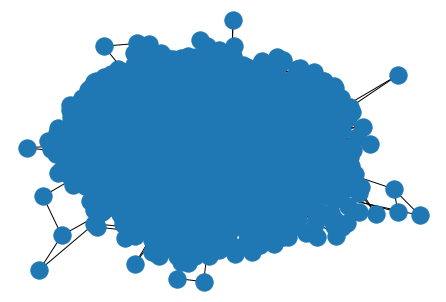

In [9]:
nx.draw(mainnet)
plt.show()

#### Ranking articulation points 

In [10]:
sorted_art_points = sorted(allArticulators,key = lambda x : -sum([len(component) for component in all_components[x]]))
#for k,v in all_components.items():
#    num_peeps = sum([len(component) for component in v])
print("Articulation points sorted by number of nodes disconnected from mainnet")
for i in range(10):
    print(sorted_art_points[i],sum([len(component) for component in all_components[sorted_art_points[i]]]))
print()
# sort the art points by degree after the components have been removed
print("Articulation points sorted by their degree after non-mainnet components are removed")
sorted_art_points = sorted(allArticulators,key = lambda x:-G.degree[x])
for i in range(10):
    print(sorted_art_points[i],sum([len(component) for component in all_components[sorted_art_points[i]]]))

Articulation points sorted by number of nodes disconnected from mainnet
023d70f2f76d283c6c4e58109ee3a2816eb9d8feb40b23d62469060a2b2867b77f 336
0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 222
0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266 151
02a0591e848d24246a349fe61c5d7a86bab7c3d9598366675b9c91deb3e31ddf57 146
0227230b7b685f1742b944bfc5d79ddc8c5a90b68499775ee10895f87307d8d22e 144
0297a77f4d1ccc55d7a10a9b137119b1103d9a9d38a5a97ffa1d0152c818fcdd0a 96
0395033b252c6f40e3756984162d68174e2bd8060a129c0d3462a9370471c6d28f 79
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b 68
03757b80302c8dfe38a127c252700ec3052e5168a7ec6ba183cdab2ac7adad3910 60
0242a4ae0c5bef18048fbecf995094b74bfb0f7391418d71ed394784373f41e4f3 53

Articulation points sorted by their degree after non-mainnet components are removed
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b 68
0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266 1

#### Generate shortest paths to find nodes with high betweeness centrality

In [23]:
# assume everyone is the same fee
# take ... 40% of the nodes and the pairs between them. find the shortest paths
# find the nodes that appear the most in the path. do a bfs from this set of nodes 
# the nodes that appear last are the 'edge' nodes 
# try connecting 4 distant edge nodes and how that affects the network 
paths=[]
paths,node_count = generate_paths(mainnet,list(mainnet.nodes()))
sorted_paths = sorted(paths,key=len,reverse=True)


# for i in range(10):
#     print(len(sorted_paths[i]))
# sorted_nodes = sorted(list(node_count.keys()),key=lambda x:-node_count[x])
# for i in range(10):
#     print(sorted_nodes[i],node_count[sorted_nodes[i]])




#### Plot shortest path lengths

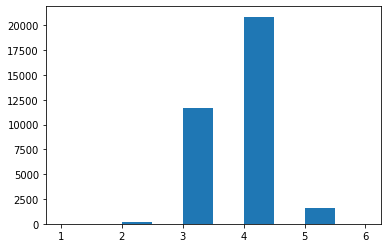

In [24]:
plt.hist([len(sorted_paths[i]) for i in range(len(sorted_paths))])
# [print(len(sorted_paths[i])) for i in range(len(sorted_paths))]
plt.show()
# most paths are length 4 (well connected network!!)

In [26]:
tree = nx.bfs_tree(mainnet,sorted_nodes[0]) 
# generate a bfs tree from the node that has highest betweeness centrality
# nodes in this tree without an out degree are farthest from the 'center'
# can be done multiple times using the top 5? nodes
# then take the intersection of all of the leaf nodes to see which nodes are farthest from all of the central nodes
# by creating channels with these leaf nodes and the central nodes, we are essentially folding the network in on itself

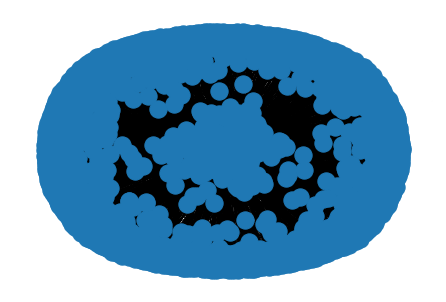

In [27]:
nx.draw(tree)
plt.show()

#### Get leaf nodes

In [28]:
leaves = [] 
for node,degree in dict(tree.out_degree).items():
    if degree==0:
        leaves.append(node)


In [29]:
print(len(leaves),len(tree.nodes))

2959 3427


#### Generate paths between leaf nodes only

In [32]:
leave_paths=[]
node_count = defaultdict(int)


leave_paths,node_count = generate_paths(mainnet,leaves)
    
    
sorted_paths = sorted(leave_paths,key=len,reverse=True)

for i in range(10):
    print(len((sorted_paths[i])))
    
sorted_nodes = sorted(list(node_count.keys()),key=lambda x:-node_count[x])
for i in range(10):
    print(sorted_nodes[i],node_count[sorted_nodes[i]])
# NOTE: There are a lot more 'long' shortest paths found

6
6
6
6
6
6
6
6
6
6
0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266 4068
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b 3662
0242a4ae0c5bef18048fbecf995094b74bfb0f7391418d71ed394784373f41e4f3 2707
03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f 2321
0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 2171
03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d 1859
03abf6f44c355dec0d5aa155bdbdd6e0c8fefe318eff402de65c6eb2e1be55dc3e 1576
0395033b252c6f40e3756984162d68174e2bd8060a129c0d3462a9370471c6d28f 1491
0390b5d4492dc2f5318e5233ab2cebf6d48914881a33ef6a9c6bcdbb433ad986d0 1426
02004c625d622245606a1ea2c1c69cfb4516b703b47945a3647713c05fe4aaeb1c 934


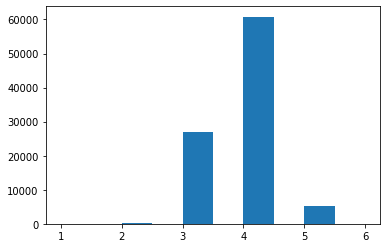

In [33]:
plt.hist([len(ele) for ele in leave_paths])
# [print(len(sorted_paths[i])) for i in range(len(sorted_paths))]
plt.show()

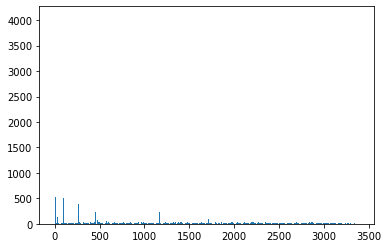

In [41]:
# print(node_count.keys(),node_count.values())
plt.bar(range(len(node_count.keys())),list(node_count.values()))
plt.show()

#### Hyperopt scratch (unfinished)

In [ ]:
centers, leaves = 1000,1000

# we only want the top nodes respectively

import hyperopt.pyll
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
import numpy as np

"""
# Add a new method as you want
@scope.define
def subbleset(choices, num_choices):
    return np.random.choice(choices, size=num_choices, replace=False)
"""
choices = range(0,100)

# Define the space like below and use in fmin
space = {
    "centers":scope.subbleset(choices,hp.randint("num_choices",0,101)),
    "leaves":scope.subbleset(choices,hp.randint("_num_choices",0,101))
}


# define an objective function
def objective(args):
    
    # indices of the top 100 leaf nodes and center nodes 
    # leaf nodes are those that appear as leafs of center nodes in a bfs  
    # and are endpoints in longest shortest paths
    # center nodes are nodes that appear most often in shortest paths 
    
    _leaves = args["leaves"]
    _centers = args["centers"]

    
    
    
    
    cost = (np.sum(_centers)+np.sum(_leaves))
    #print(cost)
    return {'loss':cost, 'status': STATUS_OK}
"""                           
# define a search space
space = {
    "leaves":[hp.choice(f'l{i}' ,[0,1]) for i in range(leaves)],
    "centers":[hp.choice(f'c{i}',[0,1]) for i in range(centers)]
}
"""
# minimize the objective over the space
best = fmin(objective, space, algo=tpe.suggest, max_evals=1000)

print(best)
#print([round(v) for v in best.values()])

print(hyperopt.space_eval(space, best))






















